<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/notebooks/L5PC_synaptic_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: https://mailmissouri-my.sharepoint.com/:w:/r/personal/drfrbc_umsystem_edu/Documents/Isaac%20synapse_tuner.docx?d=w74481c7e893e42b4b4782709409f4ed7&csf=1&web=1&e=yJlDvh

(1) tune Ben's synapses to match the in vivo data from the word doc (bullet #6.fig1.)

(2) tune synaptic weight to match the experimental data's distribution of post-synaptic current (PSC) magnitudes by region, type (#6.fig2.).

## Pre-processing

Cloning repos

Moving modfiles

Compiling modfiles

Changing directory


In [1]:
!pip install neuron
# !pip install bmtool # don't install to use the forked repo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 10.0 MB/s eta 0:00:00


In [2]:
import neuron
from neuron import h

In [3]:
# clone the other repo for its modfiles
!git clone https://github.com/davidfague/Neural-Modeling.git

Cloning into 'Neural-Modeling'...
remote: Enumerating objects: 5075, done.
remote: Counting objects: 100% (2127/2127), done.
remote: Compressing objects: 100% (822/822), done.
remote: Total 5075 (delta 1465), reused 1898 (delta 1292), pack-reused 2948 (from 1)
Receiving objects: 100% (5075/5075), 55.16 MiB | 8.11 MiB/s, done.
Resolving deltas: 100% (3423/3423), done.
Updating files: 100% (427/427), done.


In [4]:
# clone the forked repo
!git clone https://github.com/davidfague/bmtool.git

Cloning into 'bmtool'...
remote: Enumerating objects: 1872, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 1872 (delta 193), reused 242 (delta 130), pack-reused 1525 (from 1)
Receiving objects: 100% (1872/1872), 12.76 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (1169/1169), done.


In [5]:
# move the modfiles from the other repo
# https://github.com/davidfague/Neural-Modeling/tree/cleanup2/modfiles/hay -> /content/bmtool/examples/synapses

!mv Neural-Modeling/modfiles/hay/* /content/bmtool/examples/synapses/modfiles/

In [6]:
import os
os.chdir('/content/bmtool/examples/synapses')

In [7]:
import sys
sys.path.append('../../bmtool/')

In [8]:
import bmtool

In [9]:
# having 2 h.vecstim objects seems to give an error & removing one of these seemed to fix
# !rm modfiles/vecevent_coreneuron.mod # keep this one assuming it is faster or more optimized or a later version that encompasses the other
!rm modfiles/vecevent.mod

In [10]:
# if already compiled then lets delete the folder and force a recompile
if os.path.isdir('modfiles/x86_64'):
    os.system("rm -rf modfiles/x86_64 ")
# compile the mod files
if not os.path.isdir("modfiles/x86_64"):
    os.chdir('modfiles')
    print(os.system("nrnivmodl"))
    os.chdir("..")


0


In [11]:
!nrnivmodl modfiles/

/usr/local/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/content/bmtool/examples/synapses
Mod files: "modfiles/modfiles//AMPA_NMDA.mod" "modfiles/modfiles//AMPA_NMDA_STP_LTP.mod" "modfiles/modfiles//AMPA_NMDA_STP.mod" "modfiles/modfiles//cadad.mod" "modfiles/modfiles//CaDynamics_E2.mod" "modfiles/modfiles//Ca_HVA.mod" "modfiles/modfiles//cal2.mod" "modfiles/modfiles//Ca_LVAst.mod" "modfiles/modfiles//can_mig.mod" "modfiles/modfiles//epsp.mod" "modfiles/modfiles//exp2syn_stp.mod" "modfiles/modfiles//GABA_AB.mod" "modfiles/modfiles//GABA_AB_STP.mod" "modfiles/modfiles//GABA_A_STP.mod" "modfiles/modfiles//gap.mod" "modfiles/modfiles//Gfluct.mod" "modfiles/modfiles//h_kole.mod" "modfiles/modfiles//Ih.mod" "modfiles/modfiles//imCA3.mod" "modfiles/modfiles//Im.mod" "modfiles/modfiles//int2pyr.mod" "modfiles/modfiles//kap_BS.mod" "modfiles/modfiles//kBK.mod" "mod

## Synapse definitions

synapse types and parameter defaults

In [12]:
general_settings = {
    'vclamp': False, # if vclamp should start on or off used mostly for singleEventv
    'rise_interval': (0.1, 0.9), #10-90%
    'tstart': 500., # when the singleEvent should start
    'tdur': 100.,    # Dur of sim after single synaptic event has occured
    'threshold': -15., #threshold for spike in mV
    'delay': 1.3, # netcon delay
    'weight': 1., # netcon weight
    'dt': 0.1, # 0.025 # simulation dt (ms)
    'celsius': 20 # temp of sim
}

conn_type_settings = {
    'blank': {
        'spec_settings': {

        },
        'spec_syn_param': {

        }
    },
    # -------------- Ziao Synapses --------------
        'LTS': { # inhibitory perisomatic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "GABA_AB_STP",
        },
        'spec_syn_param': {
                'e_GABAA': -75.0,#-90.,
              'Use': 0.3,
              'Dep': 25.,
              'Fac': 100.
        }
    },
    'FSI': { # inhibitory perisomatic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "GABA_AB_STP",
        },
        'spec_syn_param': {
                'e_GABAA': -75.0,#-90.,
                'Use': 0.3,
                'Dep': 400.,
                'Fac': 0.
        }
    },
    'CS2CP': { # excitatory choice
        'spec_settings': {
                                   'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "AMPA_NMDA_STP",
        },
        'spec_syn_param': {
              'tau_d_AMPA': 5.2,
              'Use': 0.41,
              'Dep': 532.,
              'Fac': 65.
        }
    },
    'CP2CP': { # excitatory choice
        'spec_settings': {
                                   'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "AMPA_NMDA_STP",
        },
        'spec_syn_param': {
                'tau_d_AMPA': 5.2,
                'Use': 0.37,
                'Dep': 31.7,
                'Fac': 519.
        }
    },
    # -------------- BEN SYNAPSES -------------- https://github.com/latimerb/L5NeuronSimulation/tree/master/L5NeuronSimulation/biophys_components/synaptic_models
    'PN2PN': { # exc
        'spec_settings': {
                        'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "pyr2pyrSUM",
        },
        'spec_syn_param': {
                "AlphaTmax_ampa": 5,
                "Beta_ampa": 0.5882,
                "Cdur_ampa": .2,
                "gbar_ampa": 0.001592,# :after tuning; intially: 0.001,
                "Erev_ampa": 0,
                "AlphaTmax_nmda": 3.4483,
                "Beta_nmda": 0.0233,
                "Cdur_nmda": 0.29,
                "gbar_nmda": 0.001868, #:after tuning; initially: 0.0005,
                "Erev_nmda": 0,
                "initW": .4375, #.4375 mean computed from lognormal distribution # default listed in a file was: 5,
                # "delay": 0.9,
                "tauD1": 35,
                "d1": 0.95,
                "tauD2": 250,
                "d2": 0.8,
                "tauF": 1,
                "f": 1
        }
    },
    'PV2PN': { # inhibitory perisomatic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "int2pyr",
        },
        'spec_syn_param' : {
            "AlphaTmax_gaba": 1.52,
            "Beta_gaba": 0.14,
            "Cdur_gaba": 0.7254,
            "gbar_gaba": 0.05, #1,
            "Erev_gaba": -75,
            "initW": 1.323877, # default in ben file:1,
            "Wmax": 3,
            "Wmin": 0.25,
            # "delay": 2,
            # "con_pattern": 1,
            "lambda1": 1,
            "lambda2": 0.01,
            "threshold1": 0.5,
            "threshold2": 0.6,
            "tauD1": 51.339317,#40, #12.231593, #5.123180, #40,
            "d1": 1.275173,#0.7, #0.854166, #0.829285, #0.7,
            "tauD2":  539.965797,#500, #3603.370825, #720,#500,
            "d2": 0.763990,#0.7,#0.866754, #0.831071,#0.7,
            "tauF": 1,
            "f": 1
        }
    },
    'SOM2PN': { # inh dendritic
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "int2pyr",
        },
        'spec_syn_param': {
            "AlphaTmax_gaba": 1.52,
            "Beta_gaba": 0.14,
            "Cdur_gaba": 0.7254,
            "gbar_gaba": 0.006,
            "Erev_gaba": -75,
            "initW": 1.40353,
            "Wmax": 3,
            "Wmin": 0.25,
            # "delay": 2,
            # "con_pattern": 1,
            "lambda1": 1,
            "lambda2": 0.01,
            "threshold1": 0.5,
            "threshold2": 0.6,
            "tauD1": 251.671893,#200,
            "d1": 0.892762,#0.8,
            "tauD2": 1,
            "d2": 1,
            "tauF": 1,
            "f": 1
        }
    },
    # --------------- Greg's -----------------------
    'Fac2FSI': { # facilitating synapse
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp' : -70.,
            'sec_x': 0.5,
            'sec_id': 1,
            "level_of_detail": "AMPA_NMDA_STP",
        },
        'spec_syn_param': {
            'initW': 0.76,
            'tau_r_AMPA': 0.45,
            'tau_d_AMPA': 7.5,
            'Use': 0.13,
            'Dep': 0.,
            'Fac': 200.
        },
    },
    'Dep2FSI': { # depressing synapse
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp': -55,
            'sec_x': 0.5,
            'sec_id':0,
            "level_of_detail": "GABA_A_STP",
        },
        'spec_syn_param': {
            'initW': 20,
            'tau_r_GABAA': 0.9,
            'tau_d_GABAA': 15,
            'e_GABAA':-75,
            'Use': 0.4,
            'Dep': 190.,
            'Fac': 0.
        },
    },

}

In [13]:
# # these are old news

# # some initW defaults that we had listed before using the .json parameters.
# inh_gmax_dist: float = 5#0.5
# soma_gmax_dist: float = 5#0.5
# apic_inh_gmax_dist: float = 2.8
# basal_inh_gmax_dist: float = 2.4

# # initW that seemed to work with the correct .json parameters (before adjusting gbar_gaba (from 1 to 0.006) for inh_perisomatic)
# inh_gmax_range_apic = [7.1]
# inh_gmax_range_dend = [0.0016]
# soma_gmax_range = [0.0025]

## replacing the FSI_Cell with L5PCtemplate cell

In [14]:
# sys.path.append("/content/bmtool/bmtool/")
sys.path.append("/content/bmtool/bmtool/util/synapses.py")

In [15]:
# testing values we generate
# import numpy as np
# def log_norm_dist(gmax_mean, gmax_std, gmax_scalar, size, clip):
#   val = np.random.lognormal(gmax_mean, gmax_std, size)
#   # print(val)
#   # print(np.clip(val, clip[0], clip[1]))
#   # print(float(np.clip(val, clip[0], clip[1])))
#   s = np.clip(val, clip[0], clip[1])
#   # s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))
#   return s

# def precompute_bin_means(gmax_mean, gmax_std, gmax_scalar, clip, large_sample_size=10000):
#     # Generate a large number of log-normal distributed values
#     val = np.random.lognormal(gmax_mean, gmax_std, large_sample_size)
#     s = gmax_scalar * np.clip(val, clip[0], clip[1])

#     # Determine bins and compute the mean for each bin
#     num_bins = 10
#     bin_edges = np.percentile(s, np.linspace(0, 100, num_bins + 1))
#     bin_means = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]

#     return bin_means

# def binned_log_norm_dist(gmax_mean, gmax_std, gmax_scalar, size, clip, bin_means):
#     # Generate log-normal distributed values
#     val = np.random.lognormal(gmax_mean, gmax_std, size)
#     # Clip the values
#     s = gmax_scalar * np.clip(val, clip[0], clip[1])
#     # Assign each value to the nearest bin mean
#     binned_values = np.zeros_like(s)
#     for i in range(size):
#         # Find the bin the value belongs to
#         bin_index = np.digitize(s[i], bin_means) - 1
#         # Assign the value to the bin mean
#         binned_values[i] = bin_means[bin_index]
#     return binned_values

# exc_mean = (np.log(0.45) - 0.5 * np.log((0.35/0.45)**2+1))
# exc_std = np.sqrt(np.log((0.35/0.45)**2 + 1))
# exc_clip = (0,5)
# exc_scalar = 1

# exc_gmax_values = log_norm_dist(exc_mean, exc_std, exc_scalar, 1000, exc_clip)

# binned_log_norm_dist = binned_log_norm_dist(exc_mean, exc_std, exc_scalar, 1000, exc_clip, precompute_bin_means(exc_mean, exc_std, exc_scalar, exc_clip))

# np.mean(exc_gmax_values)



# # prompt: compare the distributions of exc_gmax_values and binned_log_norm_dist

# import matplotlib.pyplot as plt

# # Create the histograms
# plt.hist(exc_gmax_values, bins=20, alpha=0.5, label='exc_gmax_values')
# plt.hist(binned_log_norm_dist, bins=20, alpha=0.5, label='binned_log_norm_dist')

# # Add labels and title
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Comparison of Distributions')

# # Add legend
# plt.legend(loc='upper right')

# # Show the plot
# plt.show()


In [16]:
neuron.load_mechanisms('modfiles/') # have to load the mechanisms to load L5PCbiophys3.hoc

True

In [17]:
use_hay_cell = True # overwrite the target cell
if use_hay_cell:
    for cell_type,items in conn_type_settings.items():
        conn_type_settings[cell_type]['spec_settings']['post_cell'] = 'L5PCtemplate'
        conn_type_settings[cell_type]['spec_settings']['sec_id'] = 0 # 0 will be soma; 1 would be a basal dendrite


    # hoc_files_to_load = ['stdrun.hoc', "../../../Neural-Modeling/cells/templates/L5PCbiophys3.hoc", 'import3d.hoc', "../../../Neural-Modeling/cells/templates/L5PCtemplate.hoc"]

    # needed for h.load_file("import3d.hoc")
    h.load_file('stdrun.hoc')

    # load procedure L5PCbiophys() for distributing biophys in h.L5PCtemplate()
    h.load_file("../../../Neural-Modeling/cells/templates/L5PCbiophys3.hoc") # cannot be loaded without loading mechanisms first

		# # load needed procedure for importing 3d coordinates
    h.load_file("import3d.hoc")

		# # # Load h.L5PCtemplate()
    h.load_file("../../../Neural-Modeling/cells/templates/L5PCtemplateMediumRes.hoc") # load template that gets biophys and establishes sectioning
    # called 'MediumRes' because semgentation is reverted back to original

    # path to 3d coords file that will be passed to "cell = h.L5PCtemplate(template_arg)" in SynapseTuner.set_up_cell(self)
    template_arg = "../../../Neural-Modeling/cells/templates/cell1.asc" # contains 3d coordinates
else:
    template_arg=None
    hoc_files_to_load = None

In [18]:
# have to unload the mechanisms or the synapse tuner throws an error
!rm -rf x86_64
!rm -rf modfiles/x86_64

## Initialize Synaptic Tuners

In [19]:
def InitializeSysnapseTuner(connection, current_name='i', other_vars_to_record=[], sliders_to_use=['initW'], template_arg=template_arg):
  from synapses import SynapseTuner
  mechanisms_dir = 'modfiles'
  templates_file = 'templates.hoc'

  tuner = SynapseTuner(mechanisms_dir=mechanisms_dir, # where x86_64 is located
                      templates_dir=templates_file, # where the neuron templates are located
                      conn_type_settings=conn_type_settings, # dict of connection settings
                      general_settings = general_settings, # dict of general settings
                      connection = connection, # key in connection settings for which connection you want to tune
                      #json_folder_path=json_folder_path, # If your network uses json files the path can be set to update the connection settings based on the keys and values in the json
                      current_name = current_name, # name of current variable in synapase
                      other_vars_to_record = other_vars_to_record, # Other synaptic variables you wish to record besides the normal ones
                      slider_vars=sliders_to_use,
                       template_arg=template_arg) # Range variables you want to tune to adjust synaptic response.
  return tuner

ben_synapses = True
if ben_synapses:
  tunerForEXC = InitializeSysnapseTuner(connection='PN2PN',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'gbar_nmda','gbar_ampa'])
  tunerForInhPerisomatic =  InitializeSysnapseTuner(connection='PV2PN',
                                      current_name ='igaba',
                                      sliders_to_use=['initW', 'gbar_gaba', "lambda1", "lambda2", "threshold1", "threshold2", "tauD1", "d1", "tauD2", "d2", "tauF", "f"])
  tunerForInhDendritic =  InitializeSysnapseTuner(connection='SOM2PN',
                                      current_name ='igaba',
                                      sliders_to_use=['initW', 'gbar_gaba', "lambda1", "lambda2", "threshold1", "threshold2", "tauD1", "d1", "tauD2", "d2", "tauF", "f"])
else: # ziao synapses
  tunerForEXC = InitializeSysnapseTuner(connection='CS2CP',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_AMPA','Use','Dep','Fac'])
  tunerForEXC2 = InitializeSysnapseTuner(connection='CP2CP',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_AMPA','Use','Dep','Fac'])
  tunerForInhPerisomatic =  InitializeSysnapseTuner(connection='LTS',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_GABAA','Use','Dep','Fac'])
  tunerForInhDendritic =  InitializeSysnapseTuner(connection='FSI',
                                      current_name ='i',
                                      sliders_to_use=['initW', 'tau_d_GABAA','Use','Dep','Fac'])

NEURON mechanisms not found in modfiles.
NEURON mechanisms not found in modfiles.
NEURON mechanisms not found in modfiles.


In [20]:
tunerForEXC

In [21]:
  synapses = {
      'exc': tunerForEXC,
      'inhPerisomatic': tunerForInhPerisomatic,
      'inhDendritic': tunerForInhDendritic
  }

## Single event

(1) run to initialize input to the tuners

(2) check the mangitude of an individual post-synaptic-current (PSC)

exc


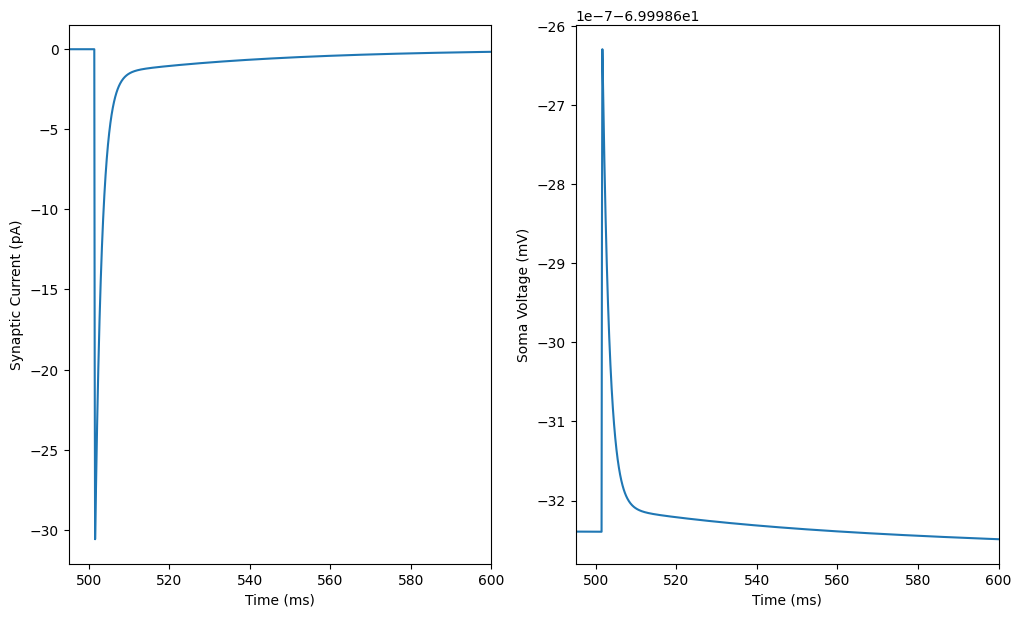

('baseline', -0.0)
('sign', -1.0)
('latency', 1.5)
('amp', 0.030592062932049236)
('rise_time', 0.1)
('decay_time', 2.0933020471592148)
('half_width', 2.8000000000000003)
Current Integral in pA*ms: -115.19
inhPerisomatic


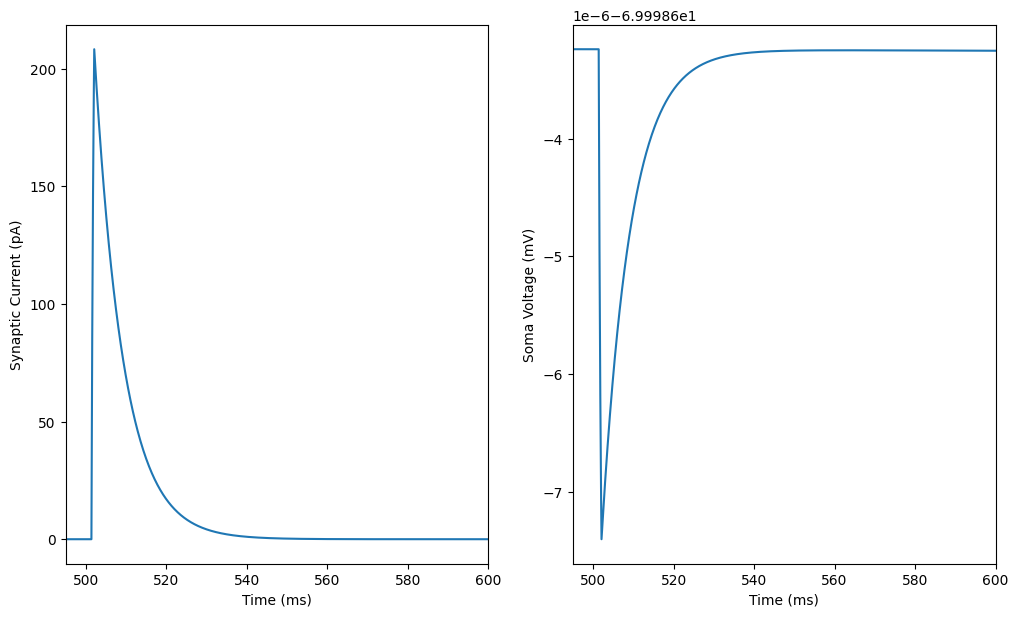

('baseline', 0.0)
('sign', 1.0)
('latency', 1.5)
('amp', 0.2083000877042412)
('rise_time', 0.5)
('decay_time', 7.142859810322373)
('half_width', 6.800000000000001)
Current Integral in pA*ms: 1574.31
inhDendritic


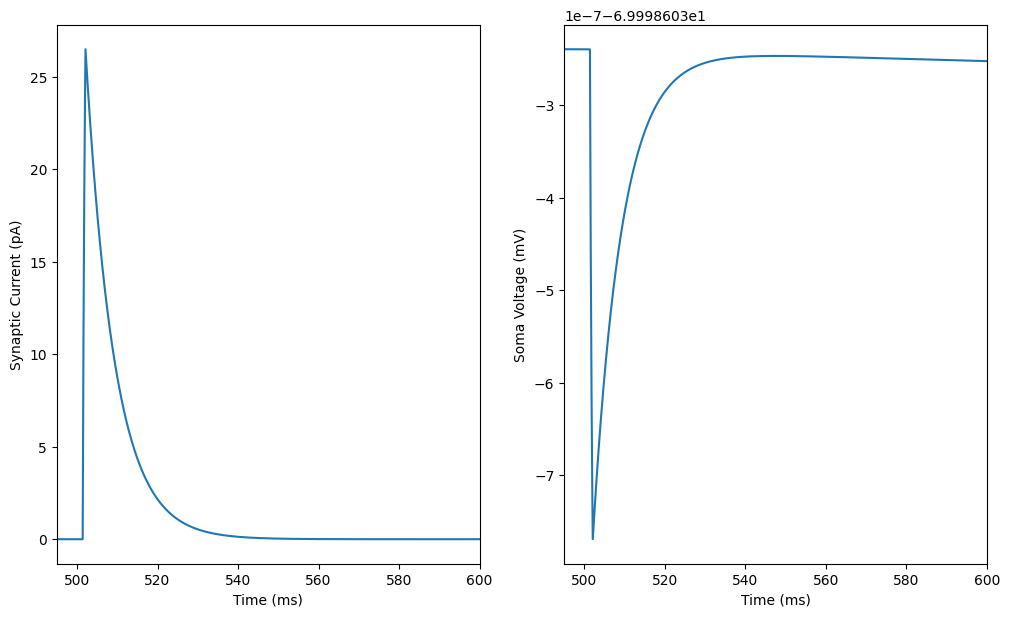

('baseline', 0.0)
('sign', 1.0)
('latency', 1.5)
('amp', 0.02649994980394299)
('rise_time', 0.5)
('decay_time', 7.142857480998197)
('half_width', 6.800000000000001)
Current Integral in pA*ms: 200.28


In [22]:
# have to run single_event to establish the input
for synapse_type,tuner in synapses.items():
  print(synapse_type)
  tuner.SingleEvent()

## Interactive Tuner

(1) select one of the synapse types

(2) check individual induction(input_freq) or PPR

(3) vary a parameter to understand how it affects the synapse

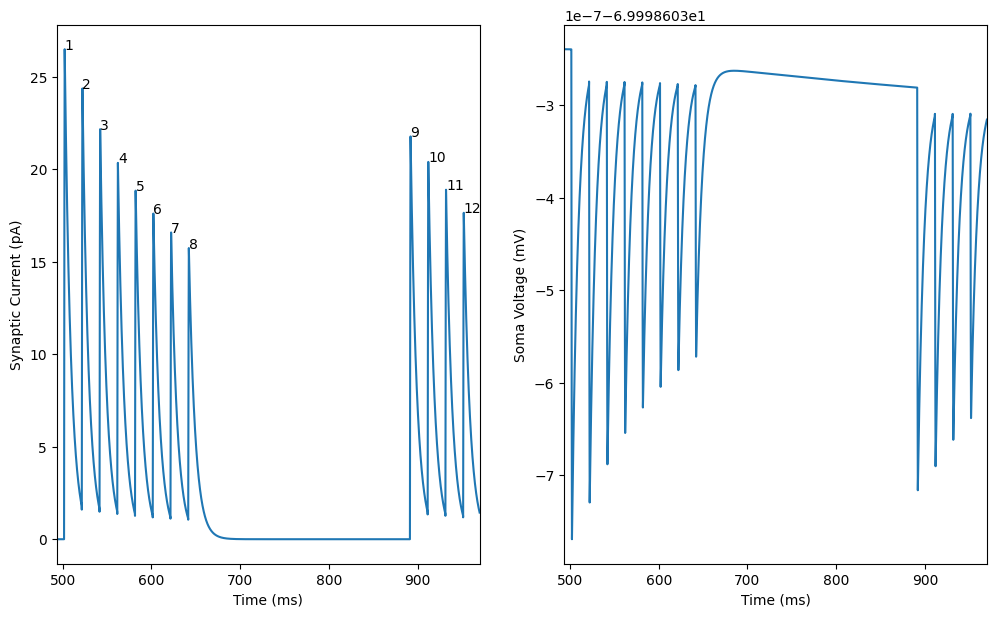


Short Term Plasticity Results for 50Hz with 250 Delay
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[24.38]]) / ([[26.5]]) = [[0.92]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[17.61, 16.59, 15.75]]) - [[26.5]] / [26.5]
([16.65]) - ([26.5]) / [26.5] = -0.372

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[21.78, 20.41, 18.9 , 17.65]]) - avg([[26.5 , 24.38, 22.18, 20.35]]) / [26.5]
([19.69]) - ([23.35]) / [26.5] = -0.138




In [23]:
# have to run to initialize input_mode. can run 1 to actually use it

# tuner_type = ['exc','inhPerisomatic','inhDendritic'][0] # select the first one
# alternatively synapses.keys(0)
for tuner_type in list(synapses.keys()):
  print(tuner_type)
  synapses[tuner_type].InteractiveTuner()

## Optimizer

(1) run to fit the value for (initW or gbar_{current_type} or others)

to the desired PSC magnitude (max ampltiude), PPR, and induction (from experimental data)

In [24]:
def auto(param_bounds, target_metrics, tuner):
  result = optimizer.optimize_parameters(
    target_metrics=target_metrics,
    param_bounds=param_bounds,
    init_guess='random', # either random or middle_guess. Random will start the synapse witha random value in the param_bound. Middle guess will pick the middle value in the param_bounds
    cost_function=custom_cost,
    method='SLSQP' # I believe this will be the fastest method, but you may try others check out https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.minimize.html
    )
  return result

In [25]:
def add_param_with_10x_range(tuner, param_bounds, param_name):
  param_bounds[param_name] = (0,tuner.conn['spec_syn_param'][param_name]*1.2)
  return param_bounds

def get_params_to_use(tuner, add_weight_params=True, add_STP_params=False):
  param_bounds = {}

  # add variables to param_bounds with their ranges
  if add_weight_params:
    if 'pyr2pyr' in tuner.conn['spec_settings']['level_of_detail']:
      param_bounds['gbar_nmda'] = (0,tuner.conn['spec_syn_param']['gbar_nmda']*10) # up to 10x the default
      param_bounds['gbar_ampa'] = (0,tuner.conn['spec_syn_param']['gbar_ampa']*10) # up to 10x the default
    elif 'int2pyr' in tuner.conn['spec_settings']['level_of_detail']:
      param_bounds['initW'] = (0,tuner.conn['spec_syn_param']['initW']*10) #up to 10x the default
      param_bounds['gbar_gaba'] = (0,tuner.conn['spec_syn_param']['gbar_gaba']*10) #up to 10x the default

  # if PPR or induction has high error include parameters in param_bounds: (should be correct already)
  if add_STP_params:
    param_bounds["tauD1"] = (0,tuner.conn['spec_syn_param']["tauD1"]*10)
    param_bounds["d1"] = (0,tuner.conn['spec_syn_param']["d1"]*10)
    param_bounds["tauD2"] = (0,tuner.conn['spec_syn_param']["tauD2"]*10)
    param_bounds["d2"] = (0,tuner.conn['spec_syn_param']["d2"]*10)

  # these actually seem to have no effect, but ths is how to insert some more.
  # if 'int2pyr' in tuner.conn['spec_settings']['level_of_detail']:
  #   for param_name in ["lambda1", "lambda2", "threshold1", "threshold2", "tauF", "f"]
  #     param_bounds = add_param_with_10x_range(tuner, param_bounds, param_name)


  return param_bounds


In [26]:
from synapses import SynapseOptimizer

synapse_type: exc
original_params: {'tauD1': 35.0, 'd1': 0.95, 'tauD2': 250.0, 'd2': 0.8}


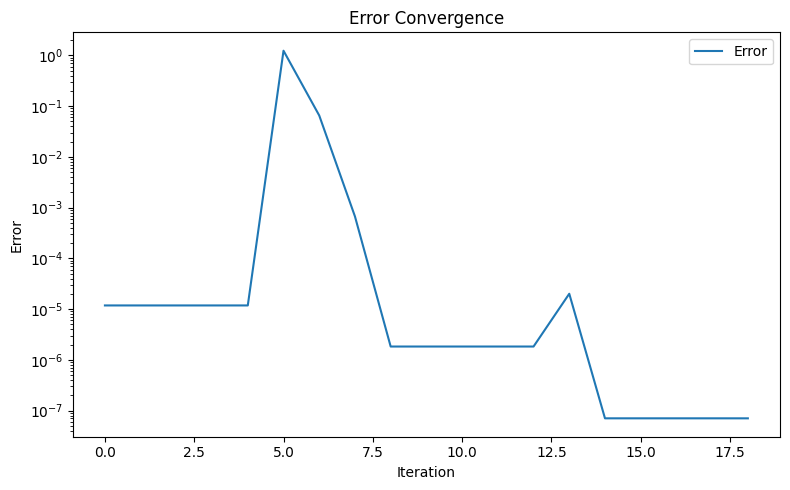

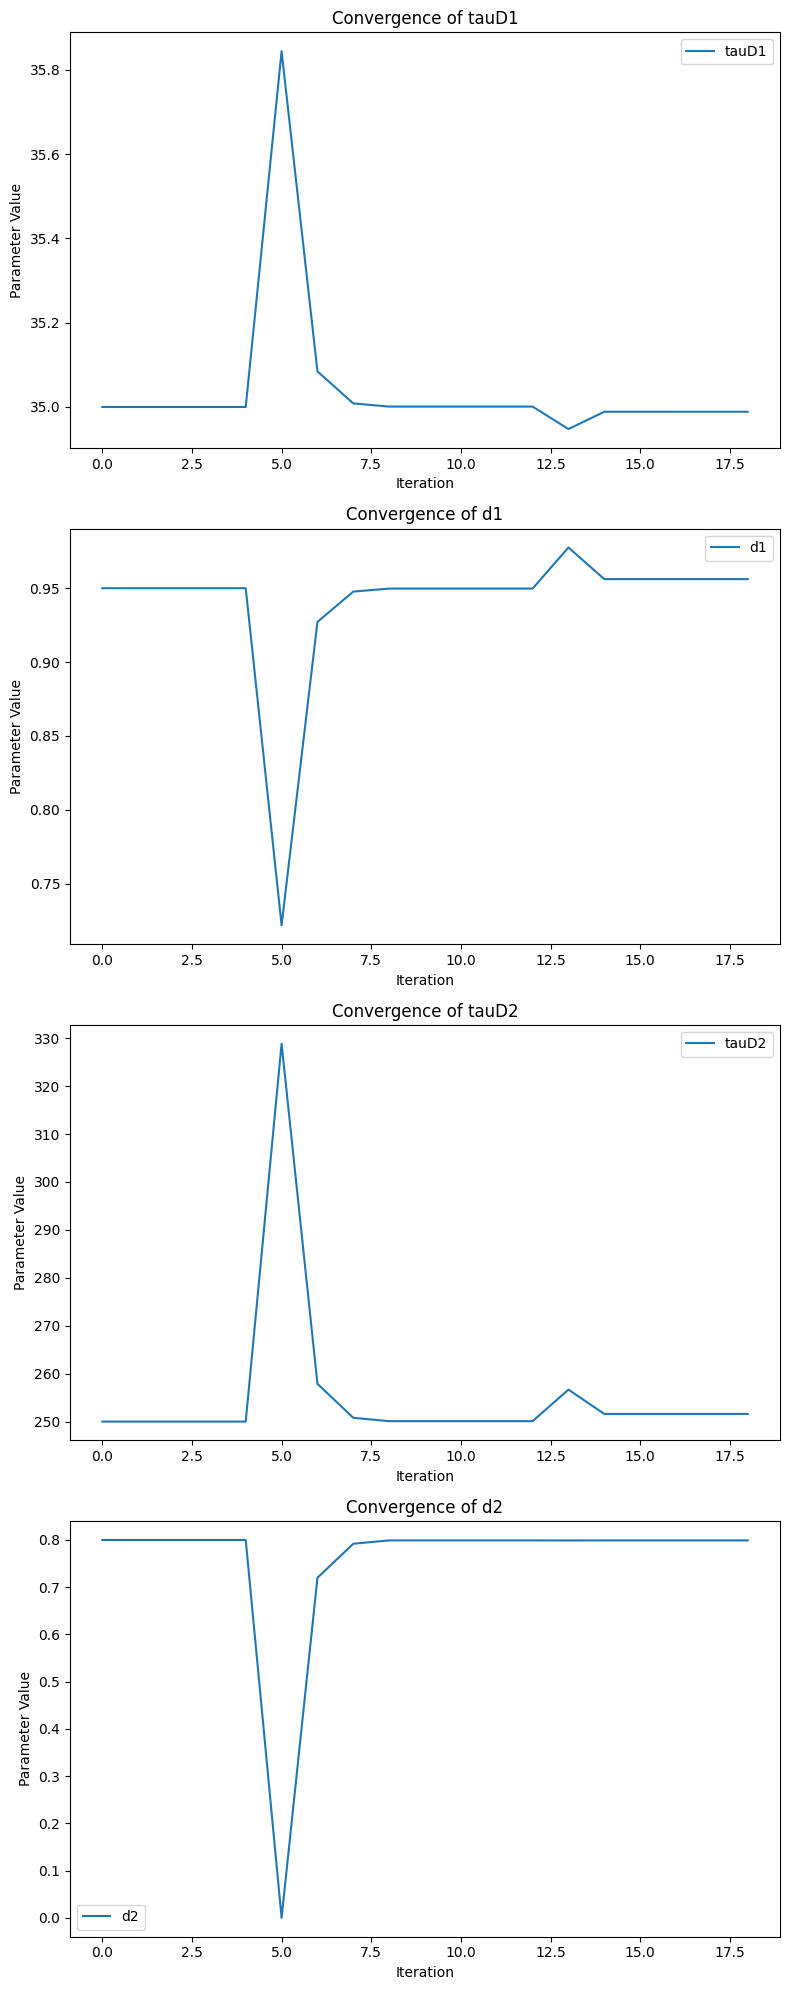

Optimization Results:
Final Error: 7.05e-08

Target Metrics:
induction: -0.440025 (target: -0.440000)
ppr: 0.833298 (target: 0.833300)
max_amplitude: 30.592063 (target: 30.600000)

Optimal Parameters:
tauD1: 34.988671
d1: 0.956141
tauD2: 251.597940
d2: 0.799090


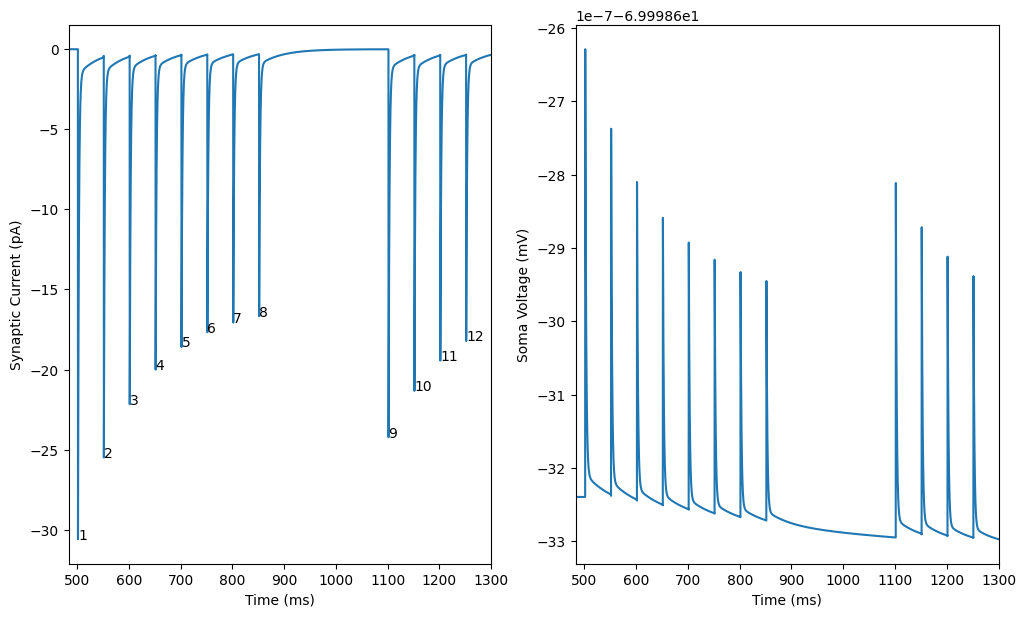


Short Term Plasticity Results for 20Hz with 250 Delay
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[25.49]]) / ([[30.59]]) = [[0.83]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[17.67, 17.06, 16.66]]) - [[30.59]] / [30.59]
([17.13]) - ([30.59]) / [30.59] = -0.440

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[24.22, 21.33, 19.44, 18.22]]) - avg([[30.59, 25.49, 22.17, 20.  ]]) / [30.59]
([20.8]) - ([24.56]) / [30.59] = -0.123




In [27]:
# NOTE maybe change the frequency of input
# NOTE train frequency is new input parameter for optimizer which we can set to the mean in the table

# CHOOSE specifications
add_weight_params = False # (mainly use initW unless it is for exc)
add_STP_params = True # if PPR or induction has high error include parameters in param_bounds: (should be correct already)
set_max_amplitude_to_mean_magnitude = True; # since optimizer cannot change weights/loc to generate a distribution
train_frequency = 20 # hz

# define the target metrics
target_metrics = { # automatically selects based on tuner_type (need to be updated to match in vivo)
    'exc': {
            'induction': -0.44, #somewhere around -0.425-0.45@20Hz#-0.6@50Hz, # from -0.75
            'ppr': 0.8333, # from 0.8
            # 'recovery': 0.0,
            'magnitude':{ #pA
                      'mean': 30.6,
                      'std': 29.9
                              }
    },
    'inhPerisomatic': {
            'induction': -0.55, #somewhere between -0.5 and -0.575 @20Hz. somewhere between -0.5 and -0.575 #-0.7 @50Hz, # from -0.75
            'ppr': 0.8666,# from 0.8
            # 'recovery': 0.0,
            'magnitude':{ #pA
                      'mean': 208.3,
                      'std': 58.7
                              }
    },
    'inhDendritic': {
            'induction': -0.275,# somewhere between -0.3 and -0.2 @20Hz. #-0.4 @50Hz, # from -0.75
            'ppr': 0.9, # from 0.8
            # 'recovery': 0.0,
            'magnitude':{ #pA
                      'mean': 26.5,
                      'std': 1.6
                              }
    }
}

# just use mean (also call it 'max_amplitude')
for synapse_type, params in target_metrics.items():
  if set_max_amplitude_to_mean_magnitude:
    target_metrics[synapse_type]['max_amplitude'] = params['magnitude']['mean']

# # currently the only metrics in the SynapseOptimizer are induction, prr, recovery, and max amplitude.
# def custom_cost(metrics, targets):
#     induction_error = (metrics['induction'] - targets['induction']) ** 2
#     ppr_error = (metrics['ppr'] - targets['ppr']) ** 2
#     # recovery_error = (metrics['recovery'] - targets['recovery']) ** 2
#     max_amp_errror = (metrics['max_amplitude'] - targets['max_amplitude']) ** 2
#     # can weight each error term differently like this
#     # return induction_error + 3 * ppr_error + recovery_error + 0.5*max_amp_errror
#     return 2*induction_error + 6 * ppr_error + 0.5*max_amp_errror

optimizers = {}
for tuner_type, tuner in synapses.items():
  optimizers[tuner_type] = SynapseOptimizer(tuner)

def custom_cost(metrics, targets):
    """
    Cost function with normalization by the target values
    (you could also use other scales)
    """
    # Avoid dividing by zero if a target is 0
    eps = 1e-9

    induction_error = ((metrics['induction'] - targets['induction']) / (targets['induction'] + eps)) ** 2
    ppr_error = ((metrics['ppr'] - targets['ppr']) / (targets['ppr'] + eps)) ** 2
    max_amp_error = ((metrics['max_amplitude'] - targets['max_amplitude']) / (targets['max_amplitude'] + eps)) ** 2
    # Weighted sum of normalized errors
    # Tweak the weights to your liking
    return 1 * induction_error + 1 * ppr_error + 1 * max_amp_error

# Run optimization with custom cost function
run_optimizer=True
if run_optimizer:
  # tuner_type = ['exc','inhPerisomatic','inhDendritic'][0] # ex. select the first one # if these keys get out of line you can use synapses.keys()[N]
  for tuner_type in [list(synapses.keys())[0]]:
    tuner = synapses[tuner_type]
    print(f"synapse_type: {tuner_type}")

    param_bounds = get_params_to_use(tuner, add_weight_params=add_weight_params, add_STP_params=add_STP_params)

    original_params = {}
    for name, value in param_bounds.items():
      original_params[name] = getattr(tuner.syn, name)

    print(f"original_params: {original_params}")

    optimizer = optimizers[tuner_type]

    result = optimizer.optimize_parameters(
        target_metrics=target_metrics[tuner_type],
        param_bounds=param_bounds,
        init_guess='original', # either random, middle_guess, or original. Random will start the synapse witha random value in the param_bound. Middle guess will pick the middle value in the param_bounds. Original will start with whatever that synapse already has
        cost_function=custom_cost,
        method='SLSQP', # I believe this will be the fastest method, but you may try others check out https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.minimize.html
        train_frequency = train_frequency
    )

    # Plot results
    optimizer.plot_optimization_results(result)

In [28]:
# testing pull optimal_params from the returned {result = SynapseOptimizationResults} https://github.com/davidfague/bmtool/blob/b6726c233dbc508549bd63bca8c15512a2c5a77c/bmtool/synapses.py#L930
if run_optimizer:
  print(result.optimal_params)

{'tauD1': 34.98867070424375, 'd1': 0.9561410488341865, 'tauD2': 251.5979401049613, 'd2': 0.7990896455538776}


## approximate initW distribution that gives in-vio PSC distribution

In [30]:
import numpy as np
def custom_cost(metrics, targets):
    """
    Cost function with normalization by the target values
    (you could also use other scales)
    """
    # Avoid dividing by zero if a target is 0
    eps = 1e-9
    max_amp_error = ((metrics['max_amplitude'] - targets['max_amplitude']) / (targets['max_amplitude'] + eps)) ** 2
    # Weighted sum of normalized errors
    # Tweak the weights to your liking
    return max_amp_error

def find_initW_for_target_PSC(target_psc, optimizer):
    """
    This function should implement (or call) your existing optimizer.
    Given a target PSC, it returns the initW that achieves (or closely achieves) that PSC.
    """
    target_metrics = {
        'max_amplitude': target_psc
    }
    param_bounds = {
        'initW': (0,tuner.syn.initW*10)
    }
    result = optimizer.optimize_parameters(
        target_metrics=target_metrics,
        param_bounds=param_bounds,
        init_guess='original', # either random, middle_guess, or original. Random will start the synapse witha random value in the param_bound. Middle guess will pick the middle value in the param_bounds. Original will start with whatever that synapse already has
        cost_function=custom_cost,
        method='SLSQP', # I believe this will be the fastest method, but you may try others check out https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.minimize.html
        train_frequency = train_frequency
    )
    return result.optimal_params['initW']

def measure_PSC(initW, tuner):
    """
    This function should measure or compute the PSC magnitude for a given initW.
    """
    tuner.syn.initW = initW
    # print(tuner.syn.initW)
    # print(tuner)
    current = tuner.SingleEvent(plot_and_print=False)
    # print(tuner.syn.initW)
    return max(abs(current))


def approximate_initW_distribution(tuner, optimizer, mu_psc, sigma_psc, epsilon=1e-1):
    """
    Given the mean PSC (mu_psc) and std PSC (sigma_psc),
    compute an approximate mean and std for initW around the operating point.

    Parameters
    ----------
    mu_psc : float
        The mean PSC magnitude in your distribution.
    sigma_psc : float
        The standard deviation of the PSC distribution.
    epsilon : float, optional
        Small offset for finite-difference slope calculation.
        Adjust as needed (e.g. 1% to 5% of your typical initW).

    Returns
    -------
    (initW_mean, initW_std) : tuple of floats
        The approximate mean and std for the initW distribution.
    """
    # print(tuner)
    print(f"\nmu_psc: {mu_psc:.4f}")
    print(f"sigma_psc: {sigma_psc:.4f}")

    print(f'\noriginal weight: {tuner.syn.initW:.4f}')
    print(f"original PSC: {measure_PSC(tuner.syn.initW, tuner):.4f}")
    # 1. Use the optimizer once to find the initW for the mean PSC
    initW_mean = find_initW_for_target_PSC(mu_psc, optimizer)
    print(f'\ncalculated mean weight: {initW_mean:.4f}')
    calculated_mean_PSC = measure_PSC(initW_mean, tuner)
    print(f"calculated mean PSC: {calculated_mean_PSC:.4f}")

    # 2. Numerically estimate the local slope (d(PSC)/dW) around initW_mean
    #    by measuring PSC at initW_mean ± epsilon
    psc_plus_weight = initW_mean + initW_mean*epsilon
    psc_minus_weight = initW_mean - initW_mean*epsilon
    print(f'psc_plus_weight: {psc_plus_weight:.4f}')
    print(f'psc_minus_weight: {psc_minus_weight:.4f}')
    psc_plus = measure_PSC(psc_plus_weight, tuner) #measure_PSC(initW_mean + epsilon, tuner)
    psc_minus = measure_PSC(psc_minus_weight, tuner) #measure_PSC(initW_mean - epsilon, tuner)
    print(f'\npsc_plus: {psc_plus:.4f}')
    print(f'psc_minus: {psc_minus:.4f}')

    # Finite difference
    slope = (psc_plus - psc_minus) / (2.0 * initW_mean * epsilon)#slope = (psc_plus - psc_minus) / (2 * epsilon)
    print(f'slope: {slope}')

    if abs(slope) < 1e-12:
        raise ValueError("Slope is essentially zero; local linear approximation is invalid here.")

    # 3. Convert PSC std to initW std (sigma_w ~ sigma_psc / slope)
    initW_std = sigma_psc / abs(slope)
    print(f'\ncalculated std weight: {initW_std:.4f}')
    calculated_plus_std = measure_PSC(initW_mean+initW_std, tuner)
    calculated_minus_std = measure_PSC(initW_mean-initW_std, tuner)
    print(f"calculated +std PSC: {calculated_plus_std:.4f}")
    print(f"calculated -std PSC: {calculated_minus_std:.4f}")
    print(f"calculated mean(+-std) PSC: {np.mean([calculated_plus_std, calculated_minus_std])}")

    print(f"\n initW_mean, initW_std: {initW_mean:.4f}, {initW_std:.4f}")

    print(f"\n std error: {sigma_psc - np.mean([calculated_plus_std, calculated_minus_std])}")
    print(f"mean error: {mu_psc - calculated_mean_PSC}")

    return initW_mean, initW_std

synapse_type = list(synapses.keys())[1]
print(synapse_type)
if hasattr(synapses[synapse_type], 'dynamic_sliders'):
  del synapses[synapse_type].dynamic_sliders # this var would replace the values even when we try to update them
initW_mean, initW_std = approximate_initW_distribution(synapses[synapse_type], optimizers[synapse_type], mu_psc=target_metrics[synapse_type]['magnitude']['mean'],
                                                       sigma_psc=target_metrics[synapse_type]['magnitude']['std'], epsilon=0.25)


mu_psc: 208.3000
sigma_psc: 58.7000

original weight: 0.9508
original PSC: 149.6001

calculated mean weight: 1.3239
calculated mean PSC: 208.3002
psc_plus_weight: 1.6548
psc_minus_weight: 0.9929

psc_plus: 260.3752
psc_minus: 156.2252
slope: 157.34084703498718

calculated std weight: 0.3731
calculated +std PSC: 267.0002
calculated -std PSC: 149.6002
calculated mean(+-std) PSC: 208.30017595057882

 initW_mean, initW_std: 1.3239, 0.3731

 std error: -149.60017595057883
mean error: -0.00018858964759260743


In [ ]:
# synapses[synapse_type].using_optimizer

In [ ]:
# initW_mean, initW_std

After optimizing, the synapse will have its values set to the final parameters.

## STP Frequency Response
Make sure that the induction/frequency curve matches in-vivo (fig 1. last column with
(1) compute induction/frequency to make sure it matches in-vivo

In [ ]:
tuner_type = ['exc','inhPerisomatic','inhDendritic'][0] # select the first one
# alternatively synapses.keys(0)
for tuner_type in synapses.keys():
  print(tuner_type)
  results = synapses[tuner_type].stp_frequency_response(log_plot = False, freqs=[10,20,50])

## Record PSC magnitude distribution across sections

(1) specify region_type (section_type) and the synapse_type

(2) compute the mean,std of the magnitude of PSCs across the cell's sections of that type

In [32]:
# could make this into a function that just computes a dictionary so we only call it once and only creating/deleting a cell once.
# Could even pass the cell from the tuner instead of creating/deleting a new one.
def get_sec_ids_from_type(section_type):
  cell = h.L5PCtemplate("../../../Neural-Modeling/cells/templates/cell1.asc")

  if section_type == 'distal_apic': # distal apic (>100 microns from soma)
    sec_ids_to_use = [idx for idx,sec in enumerate(cell.all) if (sec in cell.apic) and (h.distance(cell.soma[0](0.5), sec(0.5)) > 100)]
  elif section_type == 'distal_basal': # distal basal dendrites (>100 microns from soma)
    sec_ids_to_use = [idx for idx,sec in enumerate(cell.all) if (sec in cell.dend) and (h.distance(cell.soma[0](0.5), sec(0.5)) > 100)]
  elif section_type == 'perisomatic': # proximal dendrites and soma  (within 100 microns of soma)
    sec_ids_to_use = [idx for idx,sec in enumerate(cell.all) if (h.distance(cell.soma[0](0.5), sec(0.5)) < 100)]
  else:
    del cell
    NotImplementedError(f"{section_type} not implemented for get_sec_ids_from_type")

  del cell
  return sec_ids_to_use

gather the post synaptic current magnitude at the middle of every section

In [ ]:
# #NOTE: adjust this so that we measure across the synapses's initW distribution.

# import numpy as np
# from synapses import SynapseTuner
# import pandas as pd

# measure_PSCs = False;

# location_types_by_synapse_type = {
#     'inhPerisomatic': ['perisomatic'],
#     'exc': ['distal_basal', 'distal_apic'],
#     'inhDendritic': ['distal_basal', 'distal_apic']
# }

# # Initialize an empty list to store results
# results = []

# if measure_PSCs:
#   # gather distribution of PSC magnitudes for each synapse_type and location types
#   for synapse_type, location_types in location_types_by_synapse_type.items():
#     for location_type in location_types:
#       # get the sections we need
#       sec_ids_to_use = get_sec_ids_from_type(location_type) # select the type using integar

#       # gather PSC magnitudes across locations
#       magnitudes = []
#       for sec_id_to_use in sec_ids_to_use:

#         # move the synapse to the target location
#         synapses[synapse_type].syn.loc(list(synapses[synapse_type].cell.all)[sec_id_to_use](0.5))

#         #record magnitude of PSC
#         PSC_mag = max(abs(tuner.SingleEvent(plot_and_print=False))) # NOTE: have to update to return
#         magnitudes.append(PSC_mag) # have to fix this line

#       # calc mean, std
#       psc_mean = np.mean(magnitudes)
#       psc_std = np.std(magnitudes)
#       print(f"{synapse_type}\n")
#       print(f"{location_type}\n")
#       print(f" mean: {psc_mean}\n std:{psc_std} \n\n")

#       # Store results in the list
#       results.append({
#           "Synapse Type": synapse_type,
#           "Location Type": location_type,
#           "PSC Mean": psc_mean,
#           "PSC Std": psc_std
#       })

# # Convert the list to a DataFrame
# results_df = pd.DataFrame(results)
# # import ace_tools as tools
# # tools.display_dataframe_to_user(name="PSC Data", dataframe=results_df)

In [ ]:
import pandas as pd
import numpy as np
# gather PSC across different synaptic weights (weights only for exc; inh are fixed) & regions
measure_PSCs = True
num_weights_per_loc = 5

exc_mean = (np.log(0.45) - 0.5 * np.log((0.35/0.45)**2+1))
exc_std = np.sqrt(np.log((0.35/0.45)**2 + 1))
exc_clip = (0,5)

def log_norm_dist(gmax_mean, gmax_std, size, clip): # exc
  val = np.random.lognormal(gmax_mean, gmax_std, size)
  # print(val)
  # print(np.clip(val, clip[0], clip[1]))
  # print(float(np.clip(val, clip[0], clip[1])))
  s = np.clip(val, clip[0], clip[1])
  # s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))
  return s

def norm_dist(gmax_mean, gmax_std, size, clip): # inh
  val = np.random.normal(gmax_mean, gmax_std, size)
  s = np.clip(val, clip[0], clip[1])
  return s

location_types_by_synapse_type = {
    'inhPerisomatic': ['perisomatic'],
    'exc': ['distal_basal', 'distal_apic'],
    'inhDendritic': ['distal_basal', 'distal_apic']
}

target_metrics = { # automatically selects based on tuner_type (need to be updated to match in vivo)
    'exc': {
            'max_amplitude':{ #pA
                      'mean': 30.6,
                      'std': 29.9
                              }
    },
    'inhPerisomatic': {
            'max_amplitude':{ #pA
                      'mean': 208.3,
                      'std': 58.7
                              }
    },
    'inhDendritic': {
            'max_amplitude':{ #pA
                      'mean': 26.5,
                      'std': 1.6
                              }
    }
}
distributions_to_test = {
    'inhPerisomatic': {
        'mean': 1.323877*2,
        'std': 0.3730754
    },
    'inhDendritic': {
        'mean':1.40353*1.5,# 0.168424,
        'std': 0.0847416/2
    }
}
# inhDendritic:(0.16842415731075505, 0.08474158821873527)
# Initialize an empty list to store results
results = []

if measure_PSCs:
  # gather distribution of PSC magnitudes for each synapse_type and location types
  for synapse_type, location_types in location_types_by_synapse_type.items():
    tuner = synapses[synapse_type]
    if hasattr(synapses[synapse_type], 'dynamic_sliders'):
      del synapses[synapse_type].dynamic_sliders # this var would replace the values even when we try to update them
    if 'inh' in synapse_type:
      num_weights_per_loc_to_use = 1
      resample_weight = True
      use_norm_dist = True
    else:
      num_weights_per_loc_to_use = num_weights_per_loc
      resample_weight = True
      use_norm_dist = False

    for location_type in location_types:
      # get the sections we need
      sec_ids_to_use = get_sec_ids_from_type(location_type) # select the type using integar

      # gather PSC magnitudes across locations
      magnitudes = []

      for sec_id_to_use in sec_ids_to_use:
        # move the synapse to the target location
        tuner.syn.loc(list(tuner.cell.all)[sec_id_to_use](0.5))

        for i_weight in range(num_weights_per_loc_to_use):
          if resample_weight:
            if use_norm_dist:
              new_weight = norm_dist(distributions_to_test[synapse_type]['mean'], distributions_to_test[synapse_type]['std'], 1, (0, 10*distributions_to_test[synapse_type]['mean']))
            else:
              new_weight = log_norm_dist(exc_mean, exc_std, 1, exc_clip)
            tuner.syn.initW = new_weight

          #record magnitude of PSC
          PSC_mag = max(abs(tuner.SingleEvent(plot_and_print=False))) # NOTE: have to update to return
          magnitudes.append(PSC_mag) # have to fix this line

      print(f"target_metrics {synapse_type}: {target_metrics[synapse_type]}\n")
      # print(f"distributions_to_test {synapse_type}: {distributions_to_test[synapse_type]")

      # calc mean, std
      psc_mean = np.mean(magnitudes)
      psc_std = np.std(magnitudes)
      print(f"{synapse_type:.2f}\n")
      print(f"{location_type:.2f}\n")
      print(f" mean: {psc_mean:.2f}\n std:{psc_std:.2f} \n\n")


      # Store results in the list
      results.append({
          "Synapse Type": synapse_type,
          "Location Type": location_type,
          "PSC Mean": psc_mean,
          "PSC Std": psc_std
      })

# Convert the list to a DataFrame
results_df = pd.DataFrame(results)
# import ace_tools as tools
# tools.display_dataframe_to_user(name="PSC Data", dataframe=results_df)

<ipython-input-34-d09ae7d2f686>:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tuner.syn.initW = new_weight


inhPerisomatic

perisomatic

 mean: 91.87936732922395
 std:51.212808727007356


exc

distal_basal

 mean: 25.566405718114986
 std:14.936841997075156


exc

distal_apic

 mean: 30.51707025691452
 std:23.97382273228355


inhDendritic

distal_basal

 mean: 11.606784893259864
 std:2.5865673710209345


inhDendritic

distal_apic

 mean: 20.30838046499473
 std:7.997140893858704

inhPerisomatic

perisomatic

 mean: 88.4119165138302
 std:49.267720908238765


exc

distal_basal

 mean: 29.913590741318014
 std:24.091992160399634


exc

distal_apic

 mean: 30.847187503980834
 std:23.718409534661884


inhDendritic

distal_basal

 mean: 12.022831378094473
 std:2.710935805324831


inhDendritic

distal_apic

 mean: 21.154650552389693
 std:8.065428432904106

In [ ]:
results_df

In [ ]:
# synapses['exc'].syn.initW

In [ ]:
# looks like building the cell worked.
# # check cell properties
# sec_id = 100
# print(f"{list(synapses['exc'].cell.all)[sec_id](0.5)}: {dir(list(synapses['exc'].cell.all)[sec_id](0.5))}")

In [ ]:
# print(f"{list(synapses['exc'].cell.all)[sec_id](0.5).Ca_HVA.gCa_HVAbar}: {dir(list(synapses['exc'].cell.all)[sec_id](0.5).Ca_HVA.gCa_HVAbar)}")